### Simulation

In [8]:
import torch
import torch
import torch.optim as optim
import numpy as np
from pathlib import Path
from bmc.fid.engine import BMCSim
from bmc.optimize.optimizer import DifferentiableBMCSimWrapper  # falls du den Wrapper in optimizer.py oder einem Modul hast
from bmc.bmc_tool import prep_rf_simulation
from bmc.set_params import load_params
from bmc.utils.global_device import GLOBAL_DEVICE
from torchviz import make_dot
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython.display import display, clear_output

In [9]:
def loss_function(end_signal, pulse_params, lambda_smooth=1e-3):

    primary_loss = -end_signal
    # smoothness_loss = torch.mean(torch.abs(pulse_params[:, 1:] - pulse_params[:, :-1]))
    smoothness_loss = torch.mean(torch.abs(pulse_params[1:] - pulse_params[:-1]))
    total_loss = primary_loss + lambda_smooth * smoothness_loss
    
    return total_loss

In [10]:
seq_file = '/Users/danielmiksch/JupyterLab/optim/seq_lib/10_ETM_test.seq'
config_file = '/Users/danielmiksch/JupyterLab/optim/sim_lib/config_1pool.yaml'
seq_file = Path(seq_file).resolve()
config_file = Path(config_file).resolve()

if not Path(config_file).exists():
    raise FileNotFoundError(f"File {config_file} not found.")

if not Path(seq_file).exists():
    raise FileNotFoundError(f"File {seq_file} not found.")

sim_params = load_params(config_file)

low = -20e-6
high = 20e-6
n_iso = 10
z_pos = np.linspace(low, high, n_iso)
z_pos = torch.tensor(z_pos)
z_pos = torch.cat((z_pos, torch.tensor([0.0]))) 

sim_engine_instance = BMCSim(adc_time=5e-3,
                                params=sim_params,
                                seq_file=seq_file,
                                z_positions=z_pos,
                                n_backlog=0,
                                verbose=True,
                                webhook=False)
diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)

# rf_parameters_list = []
# for i, block_event in enumerate(diff_sim.sim_engine.seq.block_events, start=1):
#         block = diff_sim.sim_engine.seq.get_block(block_event)
#         if block.rf is not None:
#             amp_, ph_, _, _ = prep_rf_simulation(block, diff_sim.sim_engine.params.options["max_pulse_samples"])
#             block_params = torch.stack([amp_, ph_]) #[rf_amp, rf_phase, rf_freq, delay_after_pulse]
#             rf_parameters_list.append(block_params)
# if rf_parameters_list:
#     rf_parameters_tensor = torch.stack(rf_parameters_list)
#     rf_parameters_tensor.requires_grad_(True)
# else:
#     print("No RF blocks found.")

rf_parameters_list = []
for i, block_event in enumerate(diff_sim.sim_engine.seq.block_events, start=1):
    block = diff_sim.sim_engine.seq.get_block(block_event)
    if block.rf is not None:
        amp_, ph_, _, _ = prep_rf_simulation(block, diff_sim.sim_engine.params.options["max_pulse_samples"])
        rf_parameters_list.append(amp_)
if rf_parameters_list:
    rf_parameters_tensor = torch.stack(rf_parameters_list)  # Shape: (N, T)
    rf_parameters_tensor.requires_grad_(True)
else:
    print("No RF blocks found.")

In [11]:
end_signal = diff_sim(rf_parameters_tensor)
print(end_signal)
loss = loss_function(end_signal, rf_parameters_tensor)
loss.backward()
optimizer = optim.Adam([rf_parameters_tensor], lr=1e-3)
num_epochs = 500

tensor(0.0003, dtype=torch.float64, grad_fn=<MaxBackward1>)


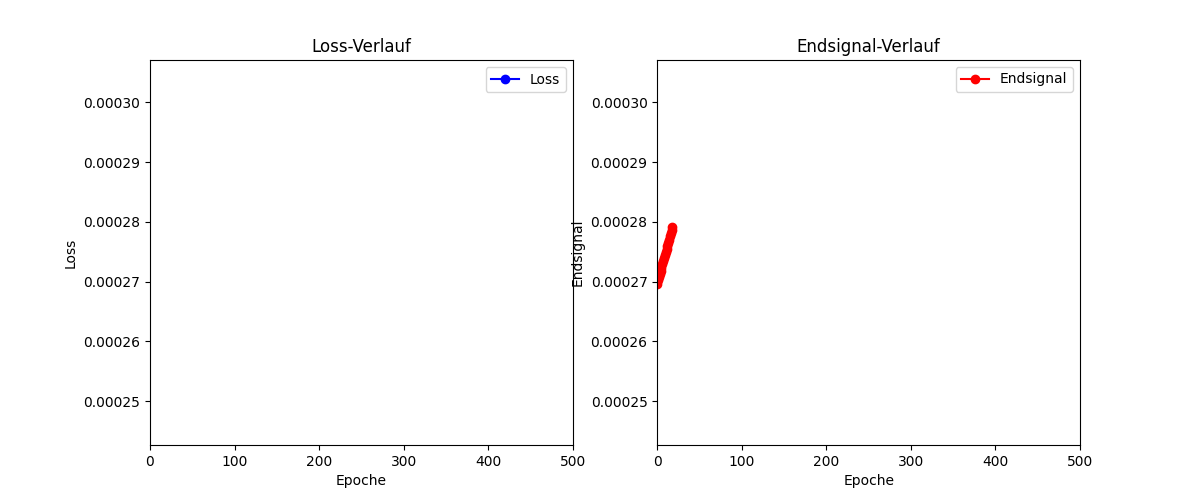

tensor([1.7500e-03, 2.1000e-03, 2.5000e-03, 3.0000e-03, 3.5500e-03, 4.2000e-03,
        4.9500e-03, 5.8500e-03, 6.9500e-03, 8.2000e-03, 9.6500e-03, 1.1350e-02,
        1.3350e-02, 1.5650e-02, 1.8350e-02, 2.1500e-02, 2.5150e-02, 2.9350e-02,
        3.4250e-02, 3.9950e-02, 4.6500e-02, 5.4050e-02, 6.2750e-02, 7.2750e-02,
        8.4250e-02, 9.7500e-02, 1.1265e-01, 1.3000e-01, 1.4980e-01, 1.7245e-01,
        1.9825e-01, 2.2765e-01, 2.6110e-01, 2.9910e-01, 3.4220e-01, 3.9100e-01,
        4.4625e-01, 5.0865e-01, 5.7905e-01, 6.5840e-01, 7.4770e-01, 8.4810e-01,
        9.6075e-01, 1.0870e+00, 1.2284e+00, 1.3864e+00, 1.5629e+00, 1.7597e+00,
        1.9788e+00, 2.2224e+00, 2.4930e+00, 2.7930e+00, 3.1253e+00, 3.4929e+00,
        3.8989e+00, 4.3467e+00, 4.8400e+00, 5.3826e+00, 5.9787e+00, 6.6326e+00,
        7.3490e+00, 8.1328e+00, 8.9890e+00, 9.9232e+00, 1.0941e+01, 1.2048e+01,
        1.3251e+01, 1.4557e+01, 1.5971e+01, 1.7501e+01, 1.9154e+01, 2.0937e+01,
        2.2858e+01, 2.4925e+01, 2.7145e+

In [12]:
%matplotlib widget
plt.plot(rf_parameters_tensor[0].detach().numpy(), '--o', markersize=3, label='RF Amplitude')
plt.show()
rf_parameters_tensor[0]

In [13]:
# for epoch in range(num_epochs):
#         sim_engine_instance = BMCSim(adc_time=5e-3,
#                                 params=sim_params,
#                                 seq_file=seq_file,
#                                 z_positions=z_pos,
#                                 n_backlog=0,
#                                 verbose=True,
#                                 webhook=False)
#         diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)
#         optimizer.zero_grad()
#         end_signal = diff_sim(rf_parameters_tensor)
#         loss = loss_function(end_signal, rf_parameters_tensor)
#         loss.backward()
#         optimizer.step()
#         # if epoch % 10 == 0:
#         print(f"Epoch {epoch}: Loss = {loss.item()}, Endsignal = {end_signal.item()}")

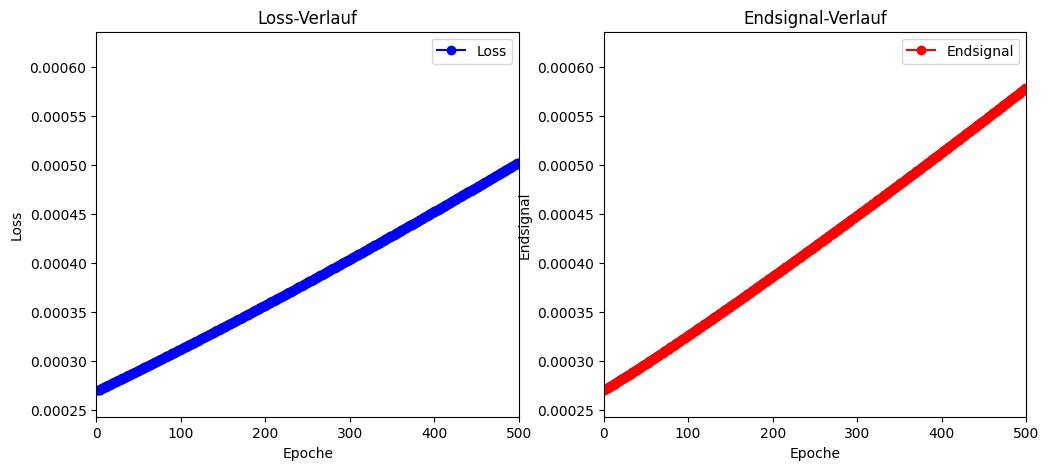

Epoch 499: Loss = -0.0005019592991347977, Endsignal = 0.0005780491914427581


In [14]:
%matplotlib widget
loss_values = []
signal_values = []
epochs = []

fig, (ax_loss, ax_signal) = plt.subplots(1, 2, figsize=(12, 5))
line_loss, = ax_loss.plot([], [], 'b-o', label='Loss')
ax_loss.set_xlabel('Epoche')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss-Verlauf')
ax_loss.legend()
line_signal, = ax_signal.plot([], [], 'r-o', label='Endsignal')
ax_signal.set_xlabel('Epoche')
ax_signal.set_ylabel('Endsignal')
ax_signal.set_title('Endsignal-Verlauf')
ax_signal.legend()

# Achsengrenzen setzen
ax_loss.set_xlim(0, num_epochs)
ax_signal.set_xlim(0, num_epochs)

# Initialzeichnung erzwingen
fig.canvas.draw()

def update_plots():
    line_loss.set_data(epochs, np.abs(loss_values))
    line_signal.set_data(epochs, signal_values)
    
    ax_loss.relim()
    ax_loss.autoscale_view(scalex=False, scaley=True)
    ax_signal.relim()
    ax_signal.autoscale_view(scalex=False, scaley=True)
    
    # Dynamische Anpassung der y-Achsengrenzen
    if loss_values:
        y_min = min(signal_values) * 0.9
        y_max = max(signal_values) * 1.1
        ax_loss.set_ylim(y_min, y_max)
    if signal_values:
        y_min = min(signal_values) * 0.9
        y_max = max(signal_values) * 1.1
        ax_signal.set_ylim(y_min, y_max)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.001)

# Beispielhafter Optimierungs-Loop:
# Annahme: rf_parameters_tensor und andere benötigte Variablen sind bereits definiert
optimizer = optim.Adam([rf_parameters_tensor], lr=1e-3)

for epoch in range(num_epochs):
    sim_engine_instance = BMCSim(adc_time=5e-3,
                                params=sim_params,
                                seq_file=seq_file,
                                z_positions=z_pos,
                                n_backlog=0,
                                verbose=True,
                                webhook=False)
    diff_sim = DifferentiableBMCSimWrapper(sim_engine_instance)
    optimizer.zero_grad()
    end_signal = diff_sim(rf_parameters_tensor)
    loss = loss_function(end_signal, rf_parameters_tensor)
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    signal_values.append(end_signal.item())
    epochs.append(epoch)
    
    update_plots()
    
    # Optional: Ausgabe des aktuellen Fortschritts
    clear_output(wait=True)
    display(fig)
    print(f"Epoch {epoch}: Loss = {loss.item()}, Endsignal = {end_signal.item()}")

plt.ioff()  # Interaktiven Modus ausschalten
# plt.show()  # Finale Darstellung des Plots


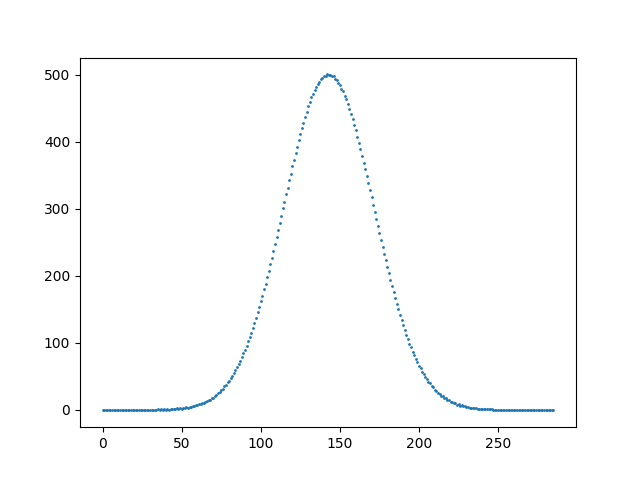

In [22]:
plt.plot(rf_parameters_tensor[0].detach().numpy(), 'o', markersize=1, label='RF Amplitude')
plt.show()

In [20]:
np.save('pulse_optim.npy', rf_parameters_tensor[0].detach().numpy())
